# Two Sigma Connect: Rental Listing Inquiries    

In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import xgboost as xgb
import re
import string
import time
import seaborn as sns
import itertools

from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt

%matplotlib inline 


# Get started

## Load data

In [2]:
train_data = pd.read_json('/kaggle/input/two-sigma-connect-rental-listing-inquiries/train.json.zip', convert_dates=['created'])
test_data = pd.read_json('/kaggle/input/two-sigma-connect-rental-listing-inquiries/test.json.zip', convert_dates=['created'])

In [3]:
train_size = train_data.shape[0]

## Create target variables

We need to convert the raw target variable into numeric

In [4]:
train_data['target'] = train_data['interest_level'].apply(lambda x: 0 if x=='low' else 1 if x=='medium' else 2)
train_data['low'] = train_data['interest_level'].apply(lambda x: 1 if x=='low' else 0)
train_data['medium'] = train_data['interest_level'].apply(lambda x: 1 if x=='medium' else 0)
train_data['high'] = train_data['interest_level'].apply(lambda x: 1 if x=='high' else 0)

## Merge training and testing data
So we don't have to perform transformations twice

In [5]:
full_data=pd.concat([train_data,test_data])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Group variables

In [6]:
num_vars = ['bathrooms','bedrooms','latitude','longitude','price']
cat_vars = ['building_id','manager_id','display_address','street_address']
text_vars = ['description','features']
date_var = 'created'
image_var = 'photos'
id_var = 'listing_id'

## Date/time features

In [7]:
full_data['created_datetime'] = pd.to_datetime(full_data['created'], format="%Y-%m-%d %H:%M:%S")
full_data['created_year']=full_data['created_datetime'].apply(lambda x:x.year) ## low variant
full_data['created_datetime'] = pd.to_datetime(full_data['created'], format="%Y-%m-%d %H:%M:%S")
full_data['created_month']=full_data['created_datetime'].apply(lambda x:x.month)
full_data['created_day']=full_data['created_datetime'].apply(lambda x:x.day)
full_data['created_dayofweek']=full_data['created_datetime'].apply(lambda x:x.dayofweek)
full_data['created_dayofyear']=full_data['created_datetime'].apply(lambda x:x.dayofyear)
full_data['created_weekofyear']=full_data['created_datetime'].apply(lambda x:x.weekofyear)
full_data['created_hour']=full_data['created_datetime'].apply(lambda x:x.hour)
full_data['created_epoch']=full_data['created_datetime'].apply(lambda x:x.value//10**9)

date_num_vars = ['created_month','created_dayofweek','created_dayofyear'
                 ,'created_weekofyear','created_hour','created_epoch']

## Geolocation features

In [8]:
full_data["geo_area_50"] = \
    full_data[['latitude', 'longitude']]\
    .apply(lambda x:(int(x[0]*50)%50)*50+(int(-x[1]*50)%50),axis=1)                                         
                         

full_data["geo_area_100"] = \
    full_data[['latitude', 'longitude']]\
    .apply(lambda x:(int(x[0]*100)%100)*100+(int(-x[1]*100)%100),axis=1)                                         
  

full_data["geo_area_200"] = \
    full_data[['latitude', 'longitude']]\
    .apply(lambda x:(int(x[0]*200)%200)*200+(int(-x[1]*200)%200),axis=1)                                         

import math

# Financial district
lat=40.705628
lon=-74.010278
full_data['distance_to_fi'] = full_data[['latitude', 'longitude']].apply(lambda x:math.sqrt((x[0]-lat)**2+(x[1]-lon)**2), axis=1)

# Central park
lat = 40.785091
lon = -73.968285
full_data['distance_to_cp'] = full_data[['latitude', 'longitude']].apply(lambda x:math.sqrt((x[0]-lat)**2+(x[1]-lon)**2), axis=1)


geo_cat_vars = ['geo_area_50', 'geo_area_100', 'geo_area_200']

geo_num_vars = ['distance_to_fi', 'distance_to_cp']

## Numeric features: basic engineering

In [9]:
full_data['rooms'] = full_data['bedrooms'] + full_data['bathrooms'] 
full_data['num_of_photos'] = full_data['photos'].apply(lambda x:len(x))
full_data['num_of_features'] = full_data['features'].apply(lambda x:len(x))
full_data['len_of_desc'] = full_data['description'].apply(lambda x:len(x))
full_data['words_of_desc'] = full_data['description'].apply(lambda x:len(re.sub('['+string.punctuation+']', '', x).split()))


full_data['nums_of_desc'] = full_data['description']\
        .apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: len([s for s in x if s.isdigit()]))
        
full_data['has_phone'] = full_data['description'].apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: [s for s in x if s.isdigit()])\
        .apply(lambda x: len([s for s in x if len(str(s))==10]))\
        .apply(lambda x: 1 if x>0 else 0)
full_data['has_email'] = full_data['description'].apply(lambda x: 1 if '@renthop.com' in x else 0)

full_data['building_id_is_zero'] = full_data['building_id'].apply(lambda x:1 if x=='0' else 0)

additional_num_vars = ['rooms','num_of_photos','num_of_features','len_of_desc',
                    'words_of_desc','has_phone','has_email','building_id_is_zero']

## Numeric-Numeric interactions

In [10]:
full_data['avg_word_len'] = full_data[['len_of_desc','words_of_desc']]\
                                    .apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
    
full_data['price_per_room'] = full_data[['price','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_bedroom'] = full_data[['price','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_bathroom'] = full_data[['price','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_feature'] = full_data[['price','num_of_features']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_photo'] = full_data[['price','num_of_photos']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_word'] = full_data[['price','words_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_by_desc_len'] = full_data[['price','len_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)


full_data['photos_per_room'] = full_data[['num_of_photos','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['photos_per_bedroom'] = full_data[['num_of_photos','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['photos_per_bathroom'] = full_data[['num_of_photos','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)

full_data['desc_len_per_room'] = full_data[['len_of_desc','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['desc_len_per_bedroom'] = full_data[['len_of_desc','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['desc_len_per_bathroom'] = full_data[['len_of_desc','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['desc_len_per_word'] = full_data[['len_of_desc','words_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['desc_len_per_numeric'] = full_data[['len_of_desc','nums_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)

full_data['features_per_room'] = full_data[['num_of_features','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_per_bedroom'] = full_data[['num_of_features','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_per_bathroom'] = full_data[['num_of_features','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_per_photo'] = full_data[['num_of_features','num_of_photos']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_per_word'] = full_data[['num_of_features','words_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_by_desc_len'] = full_data[['num_of_features','len_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)


interactive_num_vars = ['avg_word_len','price_per_room','price_per_bedroom','price_per_bathroom',
                        'price_per_feature','price_per_photo','price_per_word','price_by_desc_len',
                        'photos_per_room','photos_per_bedroom','photos_per_bathroom',
                        'desc_len_per_room','desc_len_per_bedroom','desc_len_per_bathroom','desc_len_per_word',
                        'desc_len_per_numeric','features_per_room','features_per_bedroom','features_per_bathroom',
                        'features_per_photo','features_per_word','features_by_desc_len']

## Count features

In [11]:
%%time
display=full_data["display_address"].value_counts()
manager_id=full_data["manager_id"].value_counts()
building_id=full_data["building_id"].value_counts()
street=full_data["street_address"].value_counts()
bedrooms=full_data["bedrooms"].value_counts()
bathrooms=full_data["bathrooms"].value_counts()
created_dayofyear=full_data["created_dayofyear"].value_counts()
created_weekofyear=full_data["created_weekofyear"].value_counts()

full_data["display_count"]=full_data["display_address"].apply(lambda x:display[x])
full_data["manager_count"]=full_data["manager_id"].apply(lambda x:manager_id[x])  
full_data["building_count"]=full_data["building_id"].apply(lambda x:building_id[x])
full_data["street_count"]=full_data["street_address"].apply(lambda x:street[x])
full_data["bedrooms_count"]=full_data["bedrooms"].apply(lambda x:bedrooms[x])
full_data["bathrooms_count"]=full_data["bathrooms"].apply(lambda x:bathrooms[x])
full_data["created_dayofyear_count"]=full_data["created_dayofyear"].\
    apply(lambda x:created_dayofyear[x])
full_data["created_weekofyear_count"]=full_data["created_weekofyear"].\
    apply(lambda x:created_weekofyear[x])

count_vars = ['manager_count', 'building_count', 'street_count', 'bedrooms_count',
       'bathrooms_count', 'created_dayofyear_count', 'created_weekofyear_count']

CPU times: user 15.8 s, sys: 5.94 ms, total: 15.8 s
Wall time: 15.9 s


## Numeric-categorical interactions

In [12]:
num_cat_vars =[]
price_by_manager = full_data.groupby('manager_id')['price'].agg([np.min,np.max,np.median,np.mean]).reset_index()
price_by_manager.columns = ['manager_id','min_price_by_manager',
                            'max_price_by_manager','median_price_by_manager','mean_price_by_manager']
full_data = pd.merge(full_data,price_by_manager, how='left',on='manager_id')

price_by_building = full_data.groupby('building_id')['price'].agg([np.min,np.max,np.median,np.mean]).reset_index()
price_by_building.columns = ['building_id','min_price_by_building',
                            'max_price_by_building','median_price_by_building','mean_price_by_building']
full_data = pd.merge(full_data,price_by_building, how='left',on='building_id')


full_data['price_percentile_by_manager']=\
            full_data[['price','min_price_by_manager','max_price_by_manager']]\
            .apply(lambda x:(x[0]-x[1])/(x[2]-x[1]) if (x[2]-x[1])!=0 else 0.5,
                  axis=1)
full_data['price_percentile_by_building']=\
            full_data[['price','min_price_by_building','max_price_by_building']]\
            .apply(lambda x:(x[0]-x[1])/(x[2]-x[1]) if (x[2]-x[1])!=0 else 0.5,
                  axis=1)


num_cat_vars.append('price_percentile_by_manager')
num_cat_vars.append('price_percentile_by_building')

print (num_cat_vars)

['price_percentile_by_manager', 'price_percentile_by_building']


## Two-way categorical features interactions

In [13]:
for comb in itertools.combinations(cat_vars, 2):
    comb_var_name = comb[0] +'-'+ comb[1]
    full_data [comb_var_name] = full_data [ comb[0]].astype(str) +'_' + full_data [ comb[1]].astype(str)
    cat_vars.append(comb_var_name)

cat_vars    

['building_id',
 'manager_id',
 'display_address',
 'street_address',
 'building_id-manager_id',
 'building_id-display_address',
 'building_id-street_address',
 'manager_id-display_address',
 'manager_id-street_address',
 'display_address-street_address']

## Text features

* Here we are using CountVectorizer but you are encouraged to give TfidfVectorizer a try.

* The parameter of max_features to be tuned

* The outputs are sparse matrices which can be merged with numpy arrays using scipy.stats.sparse.hstack function


In [14]:
full_data["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
cntvec = CountVectorizer(stop_words='english', max_features=200)
feature_sparse =cntvec.fit_transform(full_data["features"]\
                                     .apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x])))

feature_vars = ['feature_' + v for v in cntvec.vocabulary_]

cntvec = CountVectorizer(stop_words='english', max_features=100)
desc_sparse = cntvec.fit_transform(full_data["description"])
desc_vars = ['desc_' + v for v in cntvec.vocabulary_]


cntvec = CountVectorizer(stop_words='english', max_features=10)
st_addr_sparse = cntvec.fit_transform(full_data["street_address"])
st_addr_vars = ['desc_' + v for v in cntvec.vocabulary_]

## Categorical features - label encoding

In [15]:
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var])
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_
    
print ("Label-encoded feaures: %s" % (LE_vars))

Label Encoding building_id
Label Encoding manager_id
Label Encoding display_address
Label Encoding street_address
Label Encoding building_id-manager_id
Label Encoding building_id-display_address
Label Encoding building_id-street_address
Label Encoding manager_id-display_address
Label Encoding manager_id-street_address
Label Encoding display_address-street_address
Label-encoded feaures: ['building_id_le', 'manager_id_le', 'display_address_le', 'street_address_le', 'building_id-manager_id_le', 'building_id-display_address_le', 'building_id-street_address_le', 'manager_id-display_address_le', 'manager_id-street_address_le', 'display_address-street_address_le']


## Categorical features - one hot encoding

The output is a sparse matrix

In [16]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
OHE.fit(full_data[LE_vars])
OHE_sparse=OHE.transform(full_data[LE_vars])
                                   
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))


OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                for var in cat_vars for level in LE_map[var] ]

print ("OHE_sparse size :" ,OHE_sparse.shape)
print ("One-hot encoded catgorical feature samples : %s" % (OHE_vars[:100]))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


One-hot-encoding finished in 0.867911 seconds
OHE_sparse size : (124011, 340241)
One-hot encoded catgorical feature samples : ['building_0', 'building_00005cb939f9986300d987652c933e15', 'building_00024d77a43f0606f926e2312513845c', 'building_000ae4b7db298401cdae2b0ba1ea8146', 'building_0012f1955391bca600ec301035b97b65', 'building_0021440c04241281a436ec21accc40b1', 'building_002d1eba40aa0a6610e04ff20543585f', 'building_003d8740e21484dcc2280639b25539a4', 'building_00480e54b53fe77d17964be3f8307a99', 'building_00553d95d22484bcc36831c9248d1dbc', 'building_0055c8662ba19e95f78df97592d2b83e', 'building_0056dbdf2881b76f2a0171eb753ec9e0', 'building_0059ae562b9e338a59eaf962cb3eedd2', 'building_005e0f8d7fb7b92be351cbf1dd985149', 'building_0067f166111490e7af7f1a878a67bb5e', 'building_0070bc94a3f80aa717bb15708e98ba54', 'building_0071cda335745940cdae1dc31abfc701', 'building_0078281cd69f4bfec17e42e5cf5eecd9', 'building_0078c2ab46afba9969637ac83621901e', 'building_007ae1cd90420f18bad7b6892a9a1411', 'bui

# Modeling
We will be traning two models using three seperate datasets:

1. All numeric features + Label encoded Categorical features
2. All numeric features + One hot encoded Categorical features

## numerical features + label-encoded features

In [17]:
full_vars = num_vars + date_num_vars + interactive_num_vars+ geo_cat_vars + geo_num_vars + count_vars + LE_vars 
    
train_x = sparse.hstack([full_data[full_vars], 
                         feature_sparse, 
                         desc_sparse, 
                         st_addr_sparse]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values

test_x = sparse.hstack([full_data[full_vars], 
                        feature_sparse, 
                        desc_sparse, 
                        st_addr_sparse]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values


full_vars = full_vars + feature_vars + desc_vars + st_addr_vars    

print ("training data size: ", train_x.shape,"testing data size: ", test_x.shape)

params = dict()
params['objective'] = 'multi:softprob'
params['num_class'] = 3
params['eta'] = 0.1
params['max_depth'] = 6
params['min_child_weight'] = 1
params['subsample'] = 0.7
params['colsample_bytree'] = 0.7
params['gamma'] = 1
params['tree_method'] = 'gpu_hist' # uncomment this parameter if you are using XGBoost GPU version
params['seed']=1234

cv_results = xgb.cv(params, 
                    xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0],1)),
                    num_boost_round=1000000, 
                    nfold=5,
                    metrics={'mlogloss'},
                    seed=1234,
                    stratified=True, #set true for classification
                    shuffle=True,
                    callbacks=[xgb.callback.early_stop(50)],
                    verbose_eval=50
                   )

best_score = cv_results['test-mlogloss-mean'].min()
best_iteration = len(cv_results)
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))



training data size:  (49352, 365) testing data size:  (74659, 365)
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[0]	train-mlogloss:1.0357+0.000552323	test-mlogloss:1.03706+0.000517025
[50]	train-mlogloss:0.528065+0.00223326	test-mlogloss:0.579815+0.00492118
[100]	train-mlogloss:0.459895+0.0025035	test-mlogloss:0.556792+0.00652992
[150]	train-mlogloss:0.413818+0.00252414	test-mlogloss:0.549767+0.00701324
[200]	train-mlogloss:0.375615+0.00263409	test-mlogloss:0.546415+0.00749725
[250]	train-mlogloss:0.343852+0.00230468	test-mlogloss:0.545873+0.00781143
[300]	train-mlogloss:0.314525+0.00200818	test-mlogloss:0.546218+0.00841682
Stopping. Best iteration:
[262]	train-mlogloss:0.33664+0.0023256	test-mlogloss:0.545635+0.00807494

Best iteration: 263, best score: 0.545635


In [18]:
start = time.time()
clf = xgb.XGBClassifier(learning_rate = 0.1
                        , n_estimators =best_iteration
                        , max_depth = 6
                        , min_child_weight = 1
                        , subsample = 0.7
                        , colsample_bytree = 0.7
                        , gamma = 1
                        , seed = 1234
                        , nthread = -1
                       )

clf.fit(train_x, train_y)

print ("Training finished in %d seconds." % (time.time()-start))

preds = clf.predict_proba(test_x)
sub_df = pd.DataFrame(preds,columns = ["low", "medium", "high"])
sub_df["listing_id"] = test_data.listing_id.values
sub_df.to_csv("sub_xgb_le.csv", index=False)

Training finished in 202 seconds.


### Feature importance

#### Feature importance by XGBoost 

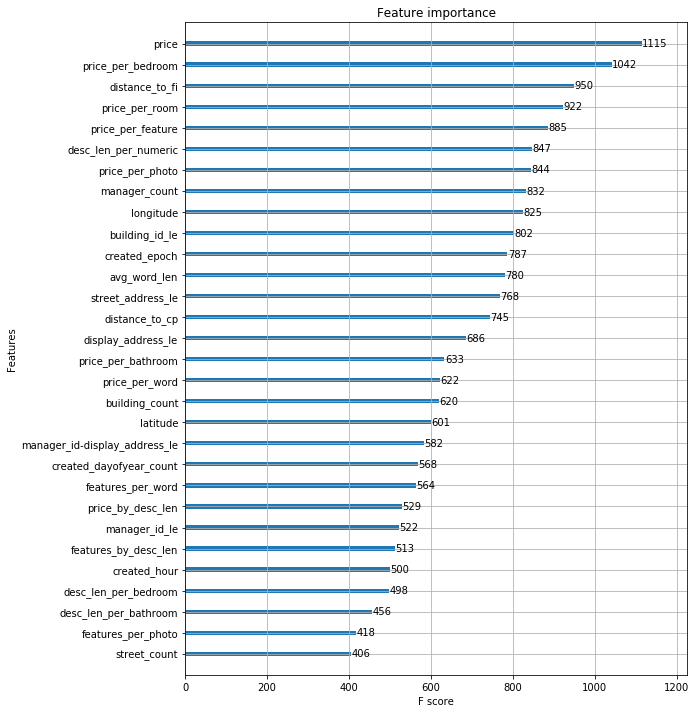

In [19]:
fig, ax = plt.subplots(1,1,figsize=(9,12))
clf.get_booster().feature_names=full_vars
xgb.plot_importance(clf, max_num_features=30, ax=ax)

# Conclusion

Feature engineering is the key, if not the most important, to the success of a data science projecct including Kaggle competition. It requires a data scientist to have excellent knowledge of Machine Learning algorithms, good sense of business, programming skills and, last but not least, hacker spirits.

In this week's lecture we've learnt how to:

* Preprocess data for
    * Numeric features
    * Categorical features
    * Date/time features
    * Text features
* Impute missing values
* Analyze feature importance



# Additional readings
* [Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/)
* [Applied Predictive Modeling - Chapter 3 Data Pre-Processing](http://appliedpredictivemodeling.com/toc/)
* [Discover Feature Engineering](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)

